# Neural Network Training
### Wavelet Extarction with Deep Learning

In this notebook I show how to use the *wtie* package to create synthetic data and train a neural network to compute a wavelet given a reflectivity series and a seismic trace.

## Create synthetic training examples
Training example are created using the function `wtie.modeling.utils.create_or_load_synthetic_dataset`. Parameters for the creation are red from a config file. The default config is provided in *experiements/parameters.yaml*. In the following we demonstarte briefly how to proceed to create synthetic examples.

In [1]:
import numpy as np
import scipy.signal

from wtie.modeling.modeling import ConvModeler

import matplotlib.pyplot as plt

# uncoment if your browser supports it
#%matplotlib notebook

In [2]:
import wtie.modeling.wavelet as _wavelet
import wtie.modeling.perturbations as _perturbations
import wtie.modeling.reflectivity as _reflectivity
import wtie.modeling.noise as _noise


from wtie.modeling.modeling import ConvModeler

In [3]:
def get_some_modeling_utils():

    dt = 0.002

    #-------------
    # Wavelets
    #-------------
    wavelet_size = 148


    # butterworth
    #order = params['wavelet']['butterworth']['order']
    order_min = 4
    order_max = 12
    low_min = 1
    low_max = 6
    high_min = 26
    high_max = 77
    rand_butt_func = _wavelet.RandomButterworthTools(lowcut_range=(low_min,low_max),
                                            highcut_range=(high_min,high_max),
                                            dt=dt,
                                            n_samples=wavelet_size,
                                            order_range=(order_min, order_max))

    # ormby
    f0_min = 2
    f0_max = 7
    f1_min = 5
    f1_max = 15
    f2_min = 20
    f2_max = 60
    f3_min = 30
    f3_max = 80
    rand_om_func = _wavelet.RandomOrmbyTools((f0_min, f0_max),
                                    (f1_min, f1_max),
                                    (f2_min, f2_max),
                                    (f3_min, f3_max),
                                    dt=dt, n_samples=wavelet_size)

    # composed
    rand_base_wlt_funcs = []
    rand_base_wlt_funcs.append(rand_butt_func)
    rand_base_wlt_funcs.append(rand_om_func)

    # perturbations
    perts = []
    perts += [_perturbations.RandomSimplexNoise(scale_range=(0.002,0.01),
                                               variation_scale_range=(wavelet_size/45, wavelet_size/25))]
    perts += [_perturbations.RandomConstantPhaseRotation(angle_range=(-35,35))]
    perts += [_perturbations.RandomSimplextPhaseRotation(scale_percentage_factor=3., max_abs_angle=30)]
    perts += [_perturbations.RandomIndependentPhaseRotation(angle_range=(-1,1))] #(-30,30)
    #perts+=[perturbations.RandomNotchFilter(dt=dt,freq_range=(50,65), band_range=(1,1))]
    #perts+=[perturbations.RandomWhitexNoise(scale=0.02)] #[0.01, 0.05]

    perts = _perturbations.Compose(perts, random_switch=False, p=.05)


    # random callable
    rnd_wlt_callable = _wavelet.RandomWaveletCallable(random_base_wavelet_gens=rand_base_wlt_funcs,
                                             perturbations=perts)
    #-------------
    # Reflectivity
    #-------------
    reflectivity_size = 251
    sr_min = .5
    sr_max = .95
    max_min = 0.3
    max_max = 0.6


    # uniform
    rnd_u_chooser = _reflectivity.RandomUniformReflectivityChooser(reflectivity_size,
                                                     sparsity_rate_range=(sr_min, sr_max))

    # weak uniform
    rnd_weak_u_chooser = _reflectivity.RandomWeakUniformReflectivityChooser(reflectivity_size,
                                                              sparsity_rate_range=(sr_min, sr_max),
                                                              max_amplitude_range=(max_min,max_max))

    # simplex
    vs_min = 10
    vs_max = 1000
    rnd_s_chooser = _reflectivity.RandomSimplexReflectivityChooser(reflectivity_size,
                                                     sparsity_rate_range=(sr_min, sr_max),
                                                     variation_scale_range=(vs_min, vs_max))

    # bi-uniform
    rnd_biu_chooser = _reflectivity.RandomBiUniformReflectivityChooser(reflectivity_size)

    # spike
    spike_ref = _reflectivity.RandomSpikeReflectivity(reflectivity_size)

    # random callable
    rnd_ref_callable = _reflectivity.RandomReflectivityCallable([rnd_u_chooser,
                                                   rnd_weak_u_chooser,
                                                   rnd_s_chooser,
                                                   rnd_biu_chooser,
                                                   spike_ref])


    #-------------
    # Noise
    #-------------
    nsc_min = 0.033
    nsc_max = 0.1
    noise_callable = _noise.RandomWhiteNoise(size=reflectivity_size, scale_range=(nsc_min,nsc_max))

    #-------------
    # Modeler
    #-------------
    params_modeler = None
    modeler = ConvModeler(kwargs=params_modeler)
    
    return rnd_wlt_callable, rnd_ref_callable, noise_callable, modeler

In [4]:
rnd_wlt_callable, rnd_ref_callable, noise_callable, modeler = get_some_modeling_utils()

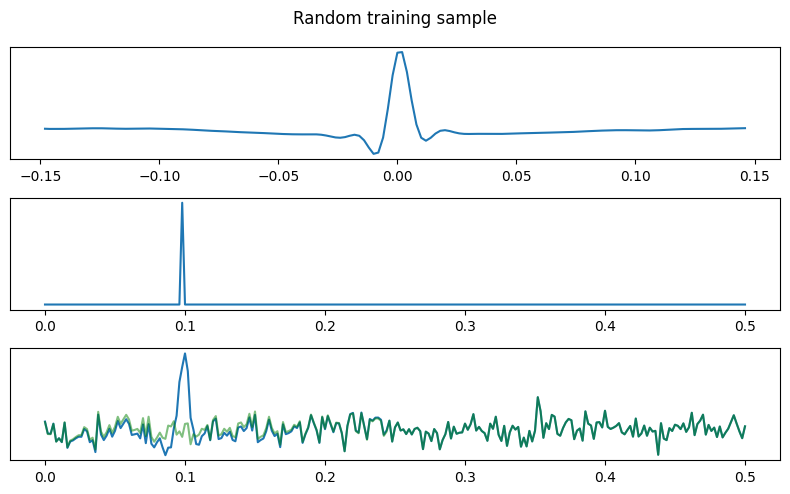

In [5]:
# run again the cell to get a new training sample

wlt = rnd_wlt_callable()
ref = rnd_ref_callable()
noise = noise_callable()
synth = modeler(wlt.y, ref, noise=noise)

fig, axes = plt.subplots(3,1, figsize=(8,5))
    
axes[0].plot(wlt.t, wlt.y)
axes[1].plot(0.002*np.arange(ref.size), ref)
axes[2].plot(0.002*np.arange(synth.size), synth)
axes[2].plot(0.002*np.arange(synth.size), noise, color='g', alpha=0.5)
    
for ax in axes.ravel():
    ax.set_yticks([])
    #ax.set_xticks([])
    
fig.suptitle("Random training sample")
fig.tight_layout()

## Train a neural network

A default architecture is provided in the file `wtie.learning.network.py`. Information on how to parameterize and train the network are provided in the README.md file.